<a href="https://colab.research.google.com/github/skdmajee/fastai/blob/master/Whatcar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Auto Classification

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py 

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate

import torch
print('pytorch version: ',torch.__version__)
import torch.utils.data as data
import fastai
print('fastai version: ',fastai.__version__)
import torchvision.models

pytorch version:  1.4.0
fastai version:  1.0.61


#Prepare for kaggle

In [0]:
!pip install kaggle --upgrade
!ls -al 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/'My Drive'/colab
kpath='/content/gdrive/My\ Drive/colab/kaggle'
!ls -al {kpath}

fastai	kaggle
total 1914283
-rw------- 1 root root 1960225373 May  5 00:42 stanford-car-dataset-by-classes-folder.zip


In [0]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [0]:
 !mkdir -p ~/.kaggle/
 !mv kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json
 !ls -al ~/.kaggle

total 16
drwxr-xr-x 2 root root 4096 May  5 00:51 .
drwx------ 1 root root 4096 May  5 00:51 ..
-rw------- 1 root root   69 May  5 00:51 kaggle.json


#Dataset
Create a path for dataset, set parents and exist_ok to True, so that it can create parent direcory if needed.

In [5]:
# !kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder -p {kpath}
!ls -al {kpath}
 

total 1914283
-rw------- 1 root root 1960225373 May  5 00:42 stanford-car-dataset-by-classes-folder.zip


In [0]:
!unzip -q {kpath}/stanford-car-dataset-by-classes-folder.zip

In [10]:
%cd
!ls -al 


/root
total 532
drwx------ 1 root root   4096 May 13 05:20 .
drwxr-xr-x 1 root root   4096 May 13 04:36 ..
-rw-r--r-- 1 root root 225299 Oct  1  2019 anno_test.csv
-rw-r--r-- 1 root root 228214 Oct  1  2019 anno_train.csv
-rw------- 1 root root   1061 May 13 05:17 .bash_history
-rw-r--r-- 1 root root   3106 Apr  9  2018 .bashrc
drwxr-xr-x 1 root root   4096 May 13 05:05 .cache
drwxr-xr-x 3 root root   4096 May 13 05:20 car_data
drwxr-xr-x 1 root root   4096 May 13 05:16 .config
drwxr-xr-x 3 root root   4096 May  8 16:17 .gsutil
drwxr-xr-x 1 root root   4096 May  8 16:45 .ipython
drwx------ 2 root root   4096 May  8 16:45 .jupyter
drwxr-xr-x 2 root root   4096 May 13 05:05 .kaggle
drwxr-xr-x 2 root root   4096 May 13 04:37 .keras
drwx------ 1 root root   4096 May  8 16:45 .local
-rw-r--r-- 1 root root   5454 Oct  1  2019 names.csv
drwxr-xr-x 3 root root   4096 May  8 16:45 .node-gyp
drwxr-xr-x 4 root root   4096 May  8 16:45 .npm
-rw-r--r-- 1 root root    148 Aug 17  2015 .profile


In [11]:
img_dir= "./car_data/car_data"
img_path=Path(img_dir)
img_path.ls()

[PosixPath('car_data/car_data/train'), PosixPath('car_data/car_data/test')]

In [0]:
test_path= Path(img_path/'test')
test_path.ls()

In [0]:
# imges=get_image_files(img_path,recurse=True)

In [0]:
# imges[:6]

In [0]:
np.random.seed(42)
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.2, max_zoom=1.2,
                      max_warp=0.2,
                      p_lighting=0.75)

In [0]:
# np.random.seed(42)
# tfms=get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1)

In [0]:
test_data=ImageDataBunch.from_folder(test_path, 
                                     no_check=True,
                                     valid_pct=0.2,
                                     ds_tfms=tfms, size=224,bs=64).normalize(imagenet_stats)

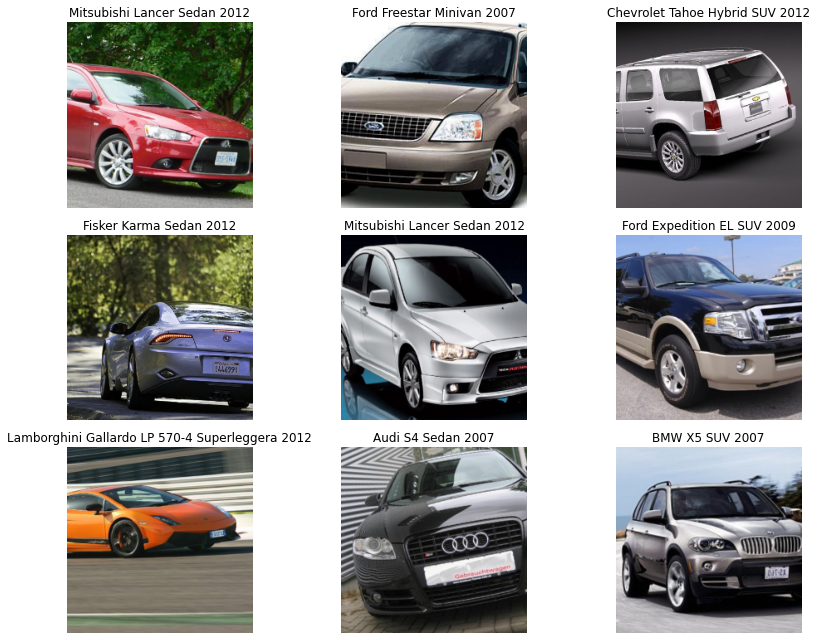

In [16]:
test_data.show_batch(3, figsize=(12,9))

In [0]:
data = ImageDataBunch.from_folder(img_path, 'train','valid','test',
                                  no_check=True,
                                  ds_tfms=tfms,
                                  valid_pct=0.2,
                                  size = 299, bs = 24).normalize(imagenet_stats)

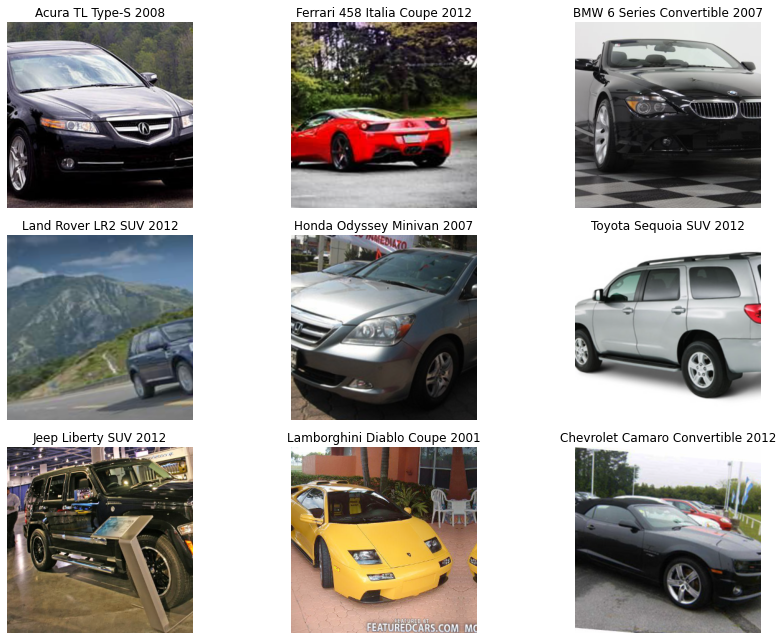

In [23]:
data.show_batch(rows=3, figsize=(12,9))

In [37]:
data.c, len(data.classes), type(data.classes)

(196, 196, list)

In [38]:
for i, c in enumerate(data.classes[34:15+34]):
  print(f'{i} : {c}')

0 : BMW X3 SUV 2012
1 : BMW X5 SUV 2007
2 : BMW X6 SUV 2012
3 : BMW Z4 Convertible 2012
4 : Bentley Arnage Sedan 2009
5 : Bentley Continental Flying Spur Sedan 2007
6 : Bentley Continental GT Coupe 2007
7 : Bentley Continental GT Coupe 2012
8 : Bentley Continental Supersports Conv. Convertible 2012
9 : Bentley Mulsanne Sedan 2011
10 : Bugatti Veyron 16.4 Convertible 2009
11 : Bugatti Veyron 16.4 Coupe 2009
12 : Buick Enclave SUV 2012
13 : Buick Rainier SUV 2007
14 : Buick Regal GS 2012


#Learning 

In [0]:
arch=models.resnet50

learn=cnn_learner(data,arch, metrics=[accuracy])

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 2.75E-03


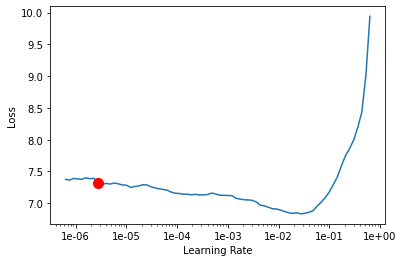

In [41]:
learn.recorder.plot(suggestion=True)

In [43]:
lr=1e-6
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,4.864653,3.587241,0.192260,05:08
1,3.345824,2.337229,0.398649,05:12
2,2.281371,1.700069,0.540541,05:12
3,1.681105,1.558885,0.607494,05:14


In [0]:
learn.save('stage-1-rn50')
learn.unfreeze()

Since CUDA run out of memeory, some search led me to clear cuda cache. Checked virtual memory and it was only 21% full. But I still got CUDA  out of memory. Then forum search led me to [lean notebook coding](https://docs.fast.ai/tutorial.resources.html). The learn.purge() is a lifesaver.

In [45]:
torch.cuda.empty_cache()
import psutil
psutil.virtual_memory()

svmem(total=13653561344, available=11331338240, percent=17.0, used=2529189888, free=1472692224, active=4572286976, inactive=6973419520, buffers=93822976, cached=9557856256, shared=216432640, slab=438034432)

In [0]:
learn.purge()

In [0]:
learn.load('stage-1-rn50')
learn.unfreeze()

#Training#2
Selecting larger image size improved the accracy to 60%. thats good since with 224 I was not able to cross 50%. 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.91E-05


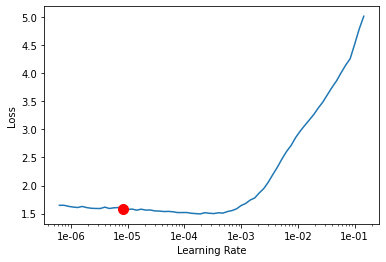

In [49]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(14, max_lr=slice(1e-05,2e-04))

epoch,train_loss,valid_loss,accuracy,time
0,1.422034,1.472573,0.620393,05:41
1,1.302933,1.294536,0.661548,05:40
2,1.131480,1.104010,0.697789,05:40
3,0.933009,1.009210,0.716830,05:40
4,0.764351,0.850796,0.773342,05:36
5,0.618088,0.799105,0.786855,05:35
6,0.465521,0.739234,0.804668,05:34
7,0.412927,0.667714,0.827396,05:35
8,0.323779,0.638902,0.829853,05:35
9,0.251695,0.624191,0.830467,05:35


In [0]:
learn.save('stage-2-rn50)')

Cool. Got to 84% acuracy.

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [53]:
learn.validate(test_data.valid_dl)

[0.85396516, tensor(0.7780)]

In [54]:
learn.validate(data.valid_dl)

[0.5740402, tensor(0.8464)]

#Interpretation
looks Ok. Let load this model and see it in action.

In [61]:
learn=learn.load('stage-2-rn50)')
interp=ClassificationInterpretation.from_learner(learn)


/usr/local/lib/python3.6/dist-packages/fastai/train.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


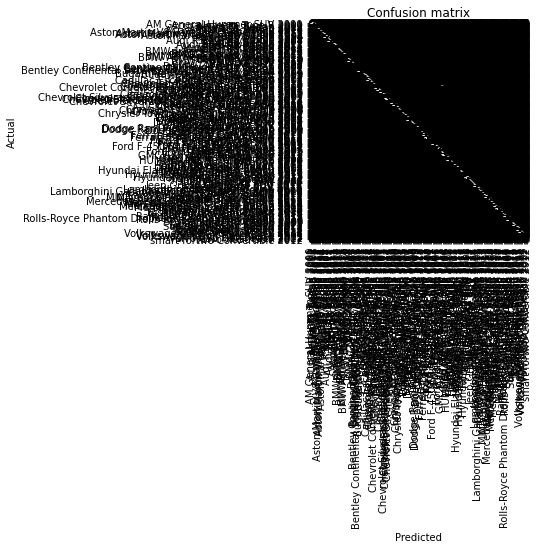

In [62]:
interp.plot_confusion_matrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


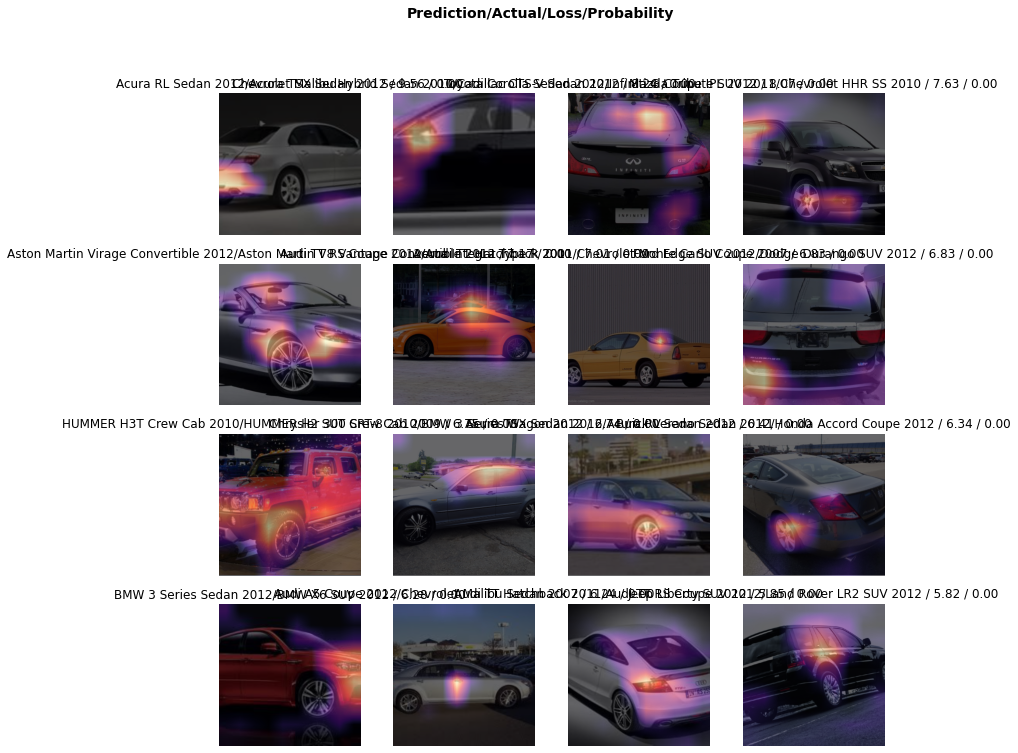

In [70]:
interp.plot_top_losses(16,largest=True, heatmap=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 9.12E-06


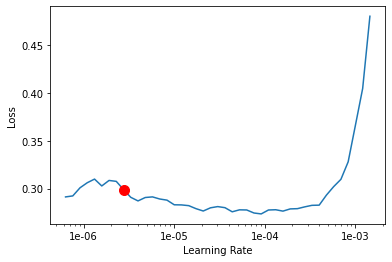

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(4,max_lr=slice(2.75e-06,1e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.267792,0.887313,0.769656,03:26
1,0.266788,0.881869,0.771499,03:26
2,0.262461,0.880796,0.774570,03:21
3,0.269985,0.883117,0.770885,03:19


Learning is complete and coverging. Lets save this

In [0]:
learn.save('stage-fin-rn50')

In [0]:
learn.validate(data.valid_dl)

[0.8831168, tensor(0.7709)]

In [0]:
learn=cnn_learner(data,arch,metrics=[accuracy, Precision(), Recall()]).load('stage-fin-rn50')

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


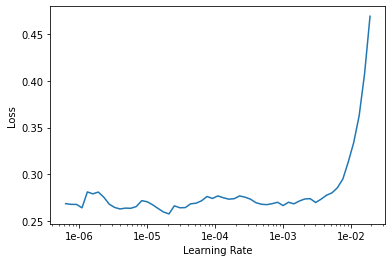

In [0]:
learn.lr_find()
learn.recorder.plot()